# Simulation Study


In [1]:
%run -i ./preamble.py
%run -i ./infer_loss_distribution.py
%config InlineBackend.figure_format = 'retina'
%load_ext nb_black

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
#dill.load_session("Sim_NegBin_Gamma.pkl")

In [3]:
import sys

print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)

tic()

Python version: 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:45:16) 
[GCC 9.3.0]
Numpy version: 1.20.2
PyMC3 version: 3.11.2
Arviz version: 0.11.2


In [4]:
FAST = False

# Processor information and SMC calibration parameters
if not FAST:
    numIters = 7
    numItersData = 10
    popSize = 1000
    epsMin = 0
    timeout = 1000
else:
    numIters = 4
    numItersData = 6
    popSize = 500
    epsMin = 1
    timeout = 30

smcArgs = {"timeout": timeout, "epsMin": epsMin, "verbose": True}
smcArgs["numProcs"] = 64

## Inference of a Negative Binomial - Weibull model

In this notebook we are are conducting a simulation experiment where the claim frequency are Negative Binomial distributed 

$$
n_s\underset{\textbf{i.i.d.}}{\sim}\text{Neg-Bin}(\alpha = 4, p = 2/3),\text{ }s = 1,\ldots, 30
$$ 

and the individual claim sizes are weibull distributed

$$
u_1,\ldots, u_{n_s}\underset{\textbf{i.i.d.}}{\sim}\text{Weib}(k = 1/2, \beta = 1),\text{ }s = 1,\ldots 30.
$$ 

The available data is aggregated claim sizes in excess of the priority $c=1$ asociated to aa global stop-loss treaty, we have 

$$
x_s = \left(\sum_{k = 1}^{n_s}u_k-c\right)_{+},\text{ }s = 1,\ldots, t.
$$

Our aim is to look into the finite sample performance of our ABC implementation when the model is well specified that is when we assume a negative binomial - weibull model

In [5]:
rg = default_rng(123)

sample_sizes = [50, 250]
T = sample_sizes[-1]
t = np.arange(1, T + 1, 1)

# Frequency-Loss Model
α, p, k, β = 4, 2/3, 1/3, 1
θ_True = α, p, k, β
θ_sev = k, β
θ_freq = α, p
freq = "negative binomial"
sev = "weibull"

# Aggregation process
c = 0.25
psi = abcre.Psi("GSL", c)

freqs, sevs = abcre.simulate_claim_data(rg, T, freq, sev, θ_True)
df_full = pd.DataFrame(
    {
        "time_period": np.concatenate([np.repeat(s, freqs[s - 1]) for s in t]),
        "claim_size": sevs,
    }
)

xData = abcre.compute_psi(freqs, sevs, psi)

df_agg = pd.DataFrame({"time_period": t, "N": freqs, "X": xData})

In [6]:
[np.sum(xData[:ss] > 0) for ss in sample_sizes]

[30, 155]

## True posterior samples

We run a Bayesian analysis on the individual claim data and frequency data so as to infer the parameters of the gamma distribution. The prior distribution on the parameters are taken as independent uniform distribution (as in the ABC approach). 

### Fitting a gamma model to the individual loss data

The true parameter will be taken as the mle of the gamma distribution based on a sample of size 10,000 

In [7]:
rg = default_rng(123)
uData_10000 = abcre.simulate_claim_sizes(rg, 10000, sev, θ_sev)
r_mle, m_mle, BIC = infer_gamma(uData_10000, [1, 1])

θ_plot = [α, p, np.NaN, np.NaN]
θ_mle = [np.NaN, np.NaN, r_mle, m_mle]

In [8]:
θ_mle

[nan, nan, 0.20703447625743115, 27.29913156044106]

The number of individual claim sizes is  98


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.016
Stage:   3 Beta: 0.076
Stage:   4 Beta: 0.339
Stage:   5 Beta: 1.000


CPU times: user 1.98 s, sys: 52.3 ms, total: 2.04 s
Wall time: 3.11 s
The number of individual claim sizes is  525


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.003
Stage:   3 Beta: 0.015
Stage:   4 Beta: 0.070
Stage:   5 Beta: 0.353
Stage:   6 Beta: 1.000


CPU times: user 1.89 s, sys: 8.05 ms, total: 1.9 s
Wall time: 1.9 s


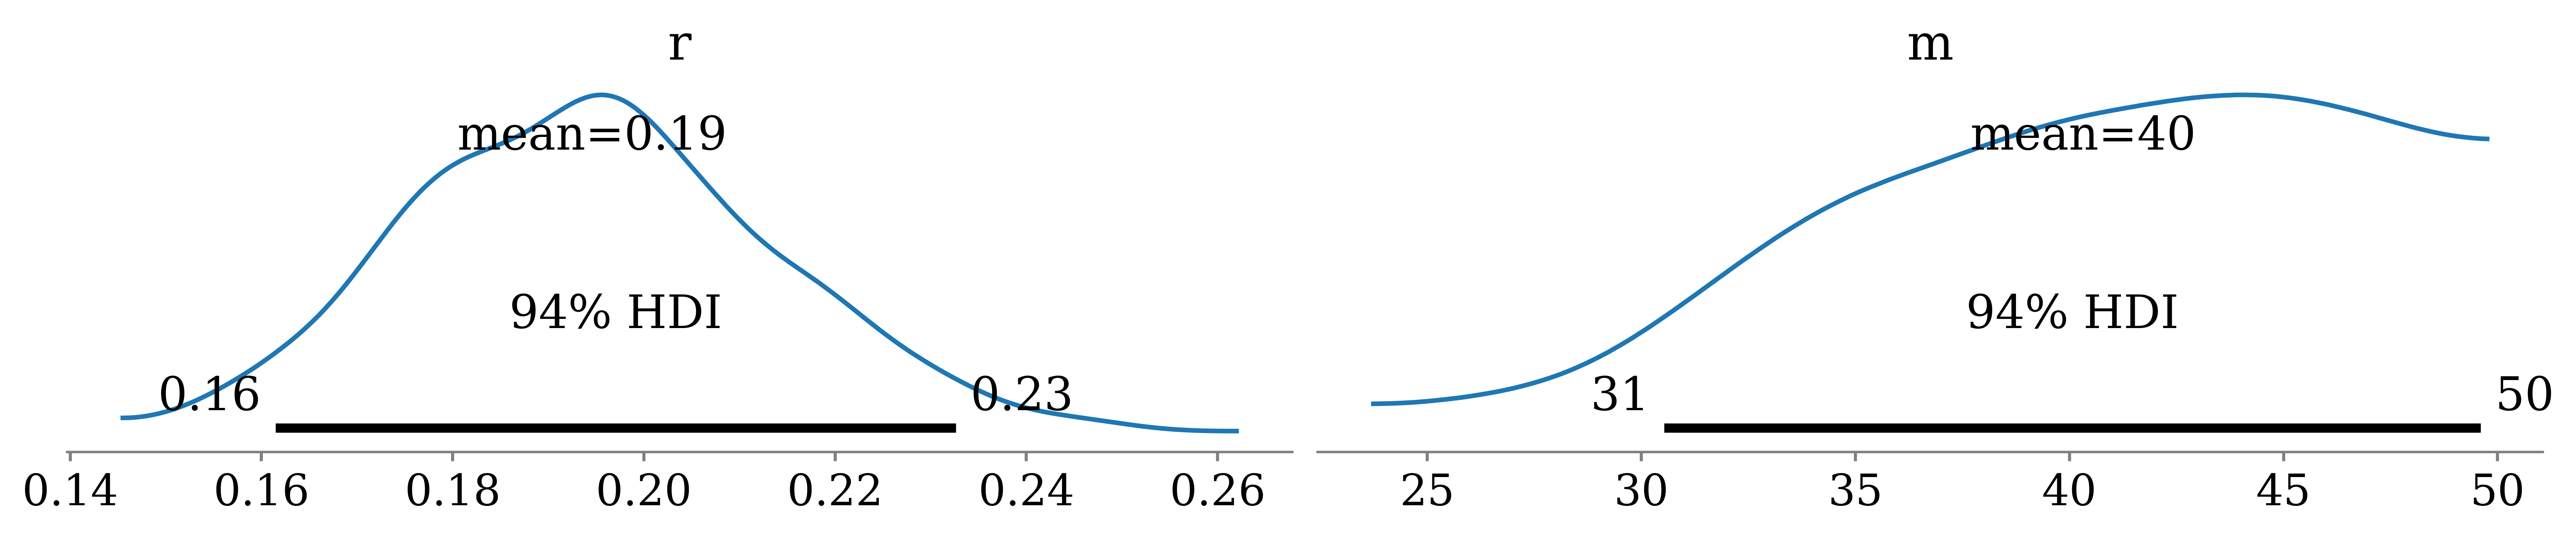

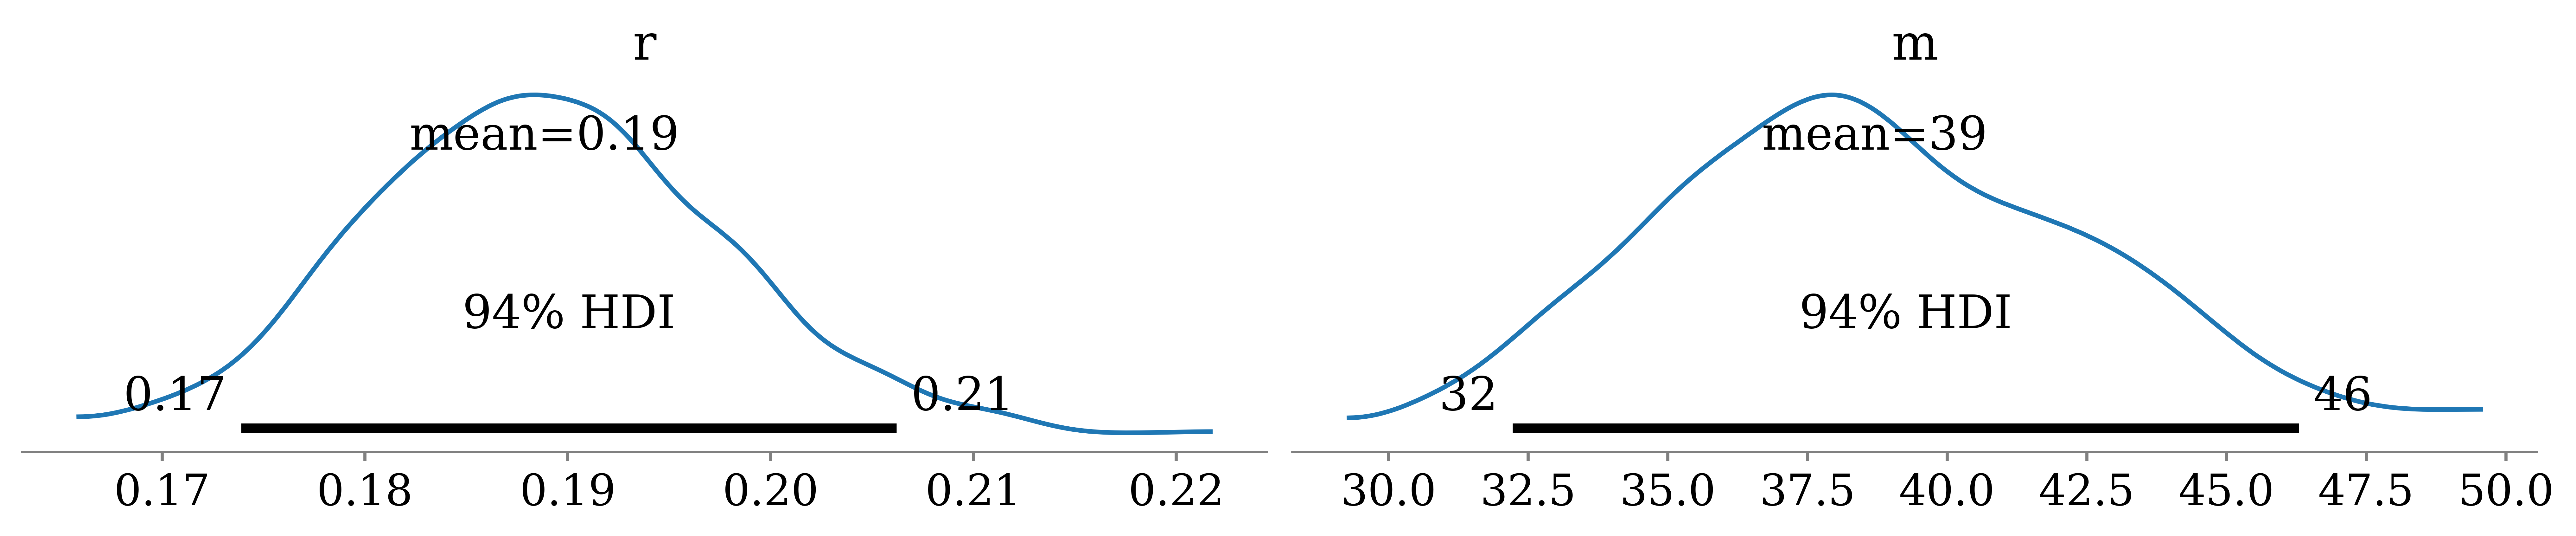

In [9]:
dfsev = pd.DataFrame({"ss": [], "r": [], "m": []})

for ss in sample_sizes:

    uData = np.array(df_full.claim_size[df_full.time_period <= ss])
    print("The number of individual claim sizes is ", len(uData))

    # We fit a gamma model using SMC
    with pm.Model() as model_gamma:
        r = pm.Uniform("r", lower=0, upper=10)
        m = pm.Uniform("m", lower=0, upper=50)

        X = pm.Gamma("X", alpha=r, beta=1 / m, observed=uData)
        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1)
        arviz.plot_posterior(trace)

    res = pd.DataFrame(
        {"ss": np.repeat(ss, popSize), "r": trace["r"], "m": trace["m"]}
    )
    dfsev = pd.concat([dfsev, res])

### Fitting a Negative Binomial model to the claim frequency data

Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.025
Stage:   1 Beta: 0.189
Stage:   2 Beta: 1.000


CPU times: user 1.67 s, sys: 24.1 ms, total: 1.69 s
Wall time: 1.69 s


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.039
Stage:   2 Beta: 0.224
Stage:   3 Beta: 0.817
Stage:   4 Beta: 1.000


CPU times: user 2.08 s, sys: 8.1 ms, total: 2.09 s
Wall time: 2.09 s


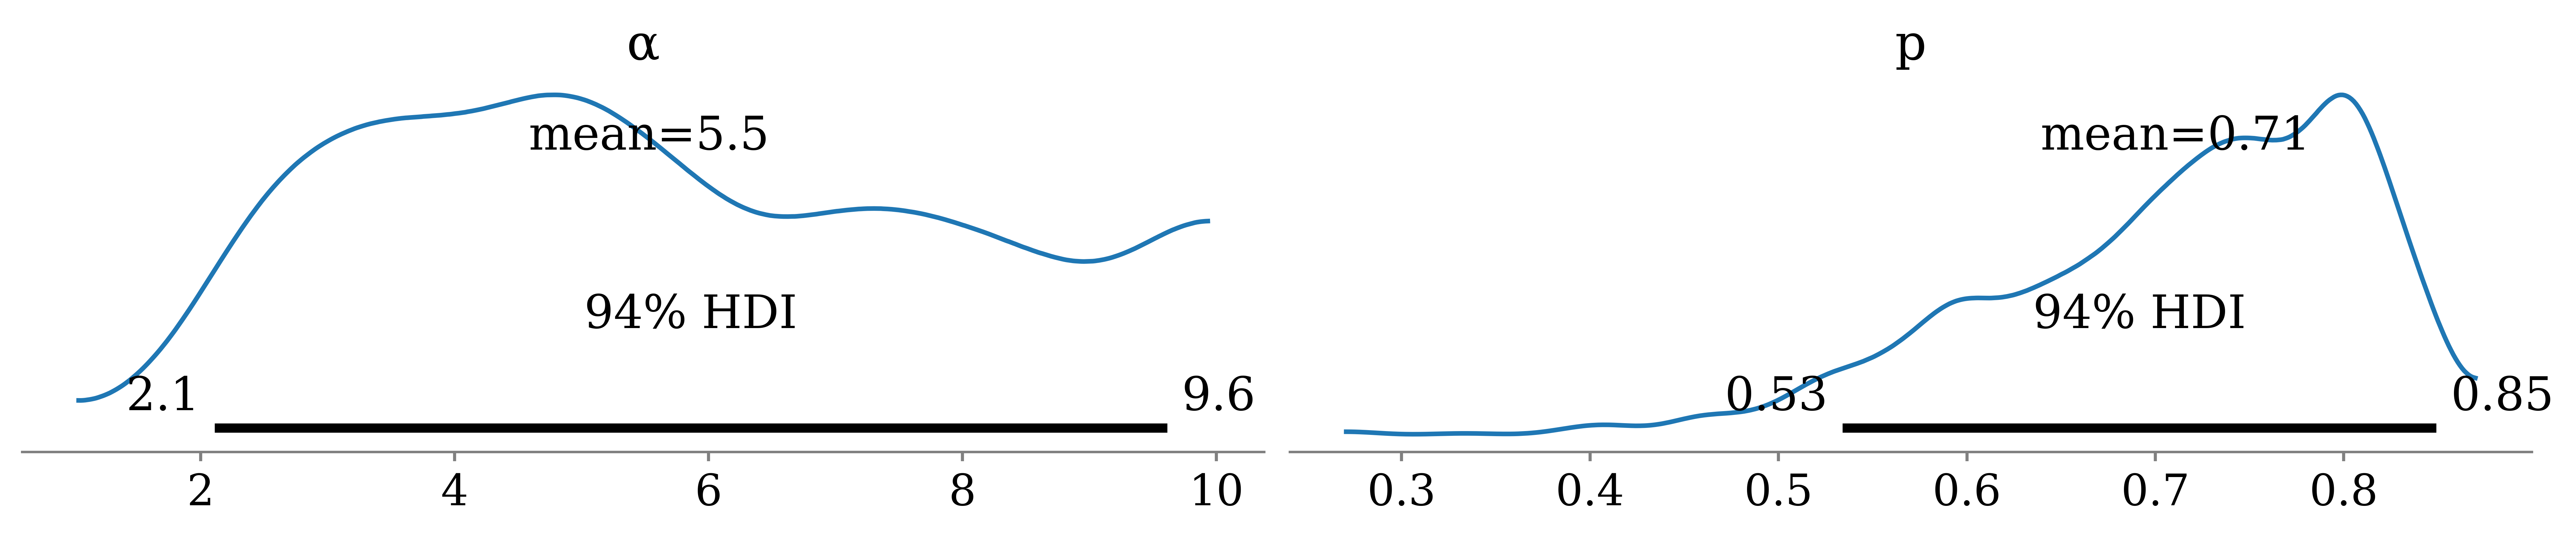

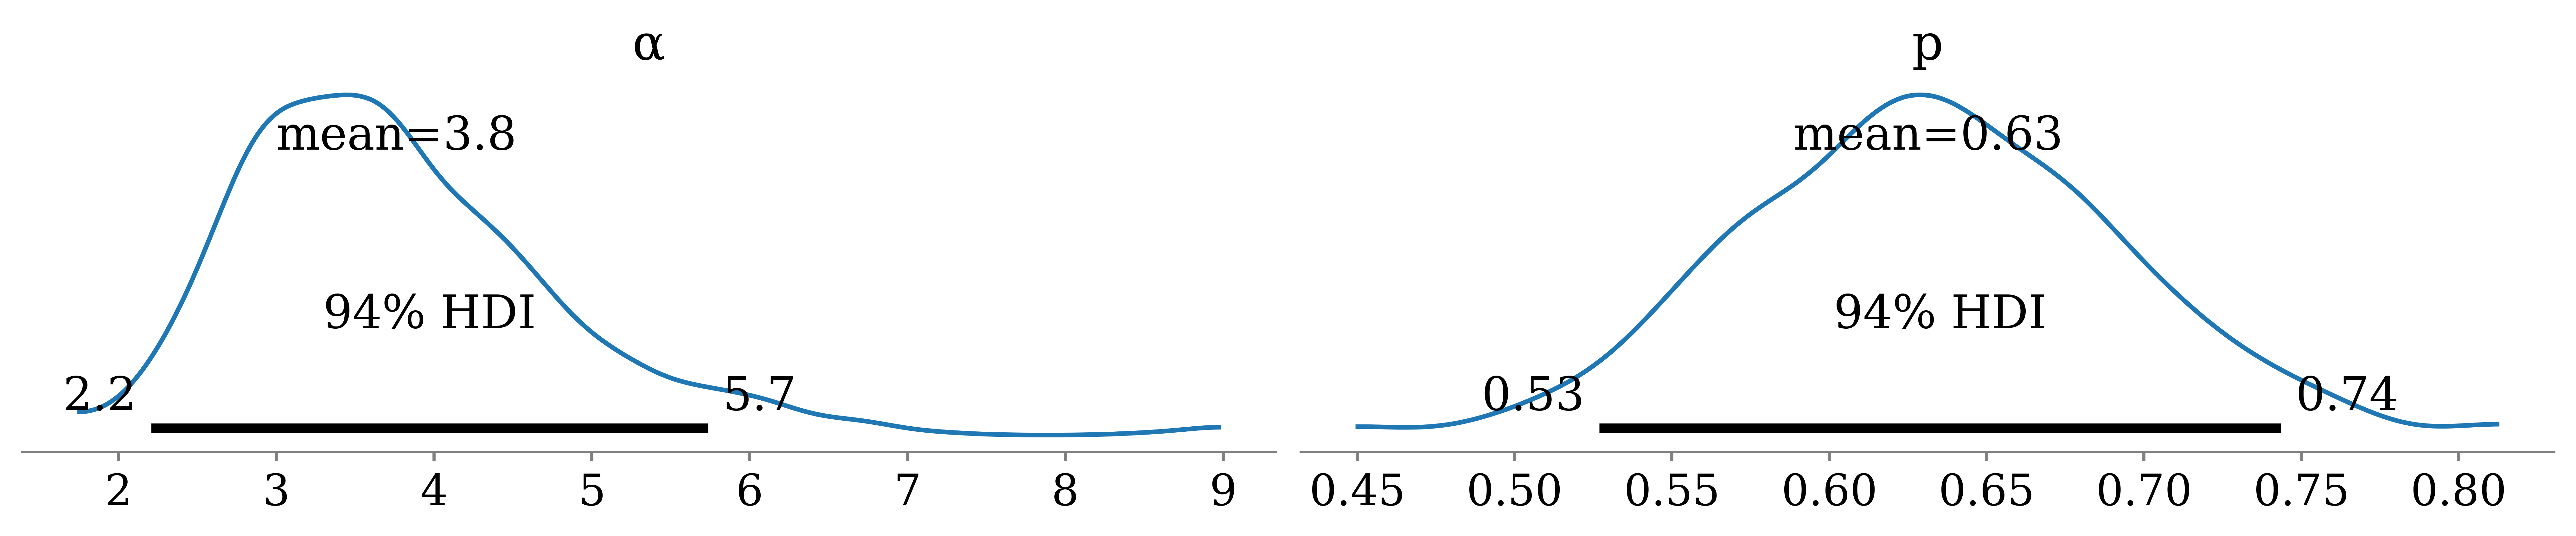

In [10]:
dffreq = pd.DataFrame({"ss": [], "α": [], "p": []})

for ss in sample_sizes:
    nData = df_agg.N[df_agg.time_period <= ss]
    with pm.Model() as model_negbin:
        α = pm.Uniform("α", lower=0, upper=10)
        p = pm.Uniform("p", lower=1e-3, upper=1)
        N = pm.NegativeBinomial("N", mu=α * (1 - p) / p, alpha=α, observed=nData)

        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1)
        arviz.plot_posterior(trace)

    res = pd.DataFrame(
        {"ss": np.repeat(ss, popSize), "α": trace["α"], "p": trace["p"]}
    )
    dffreq = pd.concat([dffreq, res])

We store all the posterior samples in one single data frame

In [11]:
dftrue = pd.concat([dffreq, dfsev.drop("ss", axis=1)], axis=1)
dftrue["posterior"] = np.repeat("True", len(dftrue))

## ABC posterior for the negative-binomial-gamma model

In [12]:
params = ("α", "p", "r", "m")
prior = abcre.IndependentUniformPrior([(0, 10), (1e-3, 1), (0, 10), (0, 50)], params)
model = abcre.Model("negative binomial", "gamma", psi, prior)

In [13]:
dfABC = pd.DataFrame({'ss':[],'weights':[],'α':[],'p':[],'r':[],'m':[]})

for ss in sample_sizes:
    xDataSS = df_agg.X[df_agg.time_period <= ss].to_numpy()

    %time fit = abcre.smc(numIters, popSize, xDataSS, model, **smcArgs)

    res = pd.DataFrame({'ss':np.repeat(ss, popSize),
                                     'weights': fit.weights,
                                     'α': fit.samples[:,0],
                                     'p': fit.samples[:,1],
                                     'r': fit.samples[:,2],
                                     'm': fit.samples[:,3]})

    dfABC = pd.concat([dfABC, res])

Final population dists <= 10.93, ESS = 778
CPU times: user 14.5 s, sys: 1.25 s, total: 15.8 s
Wall time: 22.1 s


Final population dists <= 7.33, ESS = 607
CPU times: user 9.33 s, sys: 521 ms, total: 9.85 s
Wall time: 17.9 s


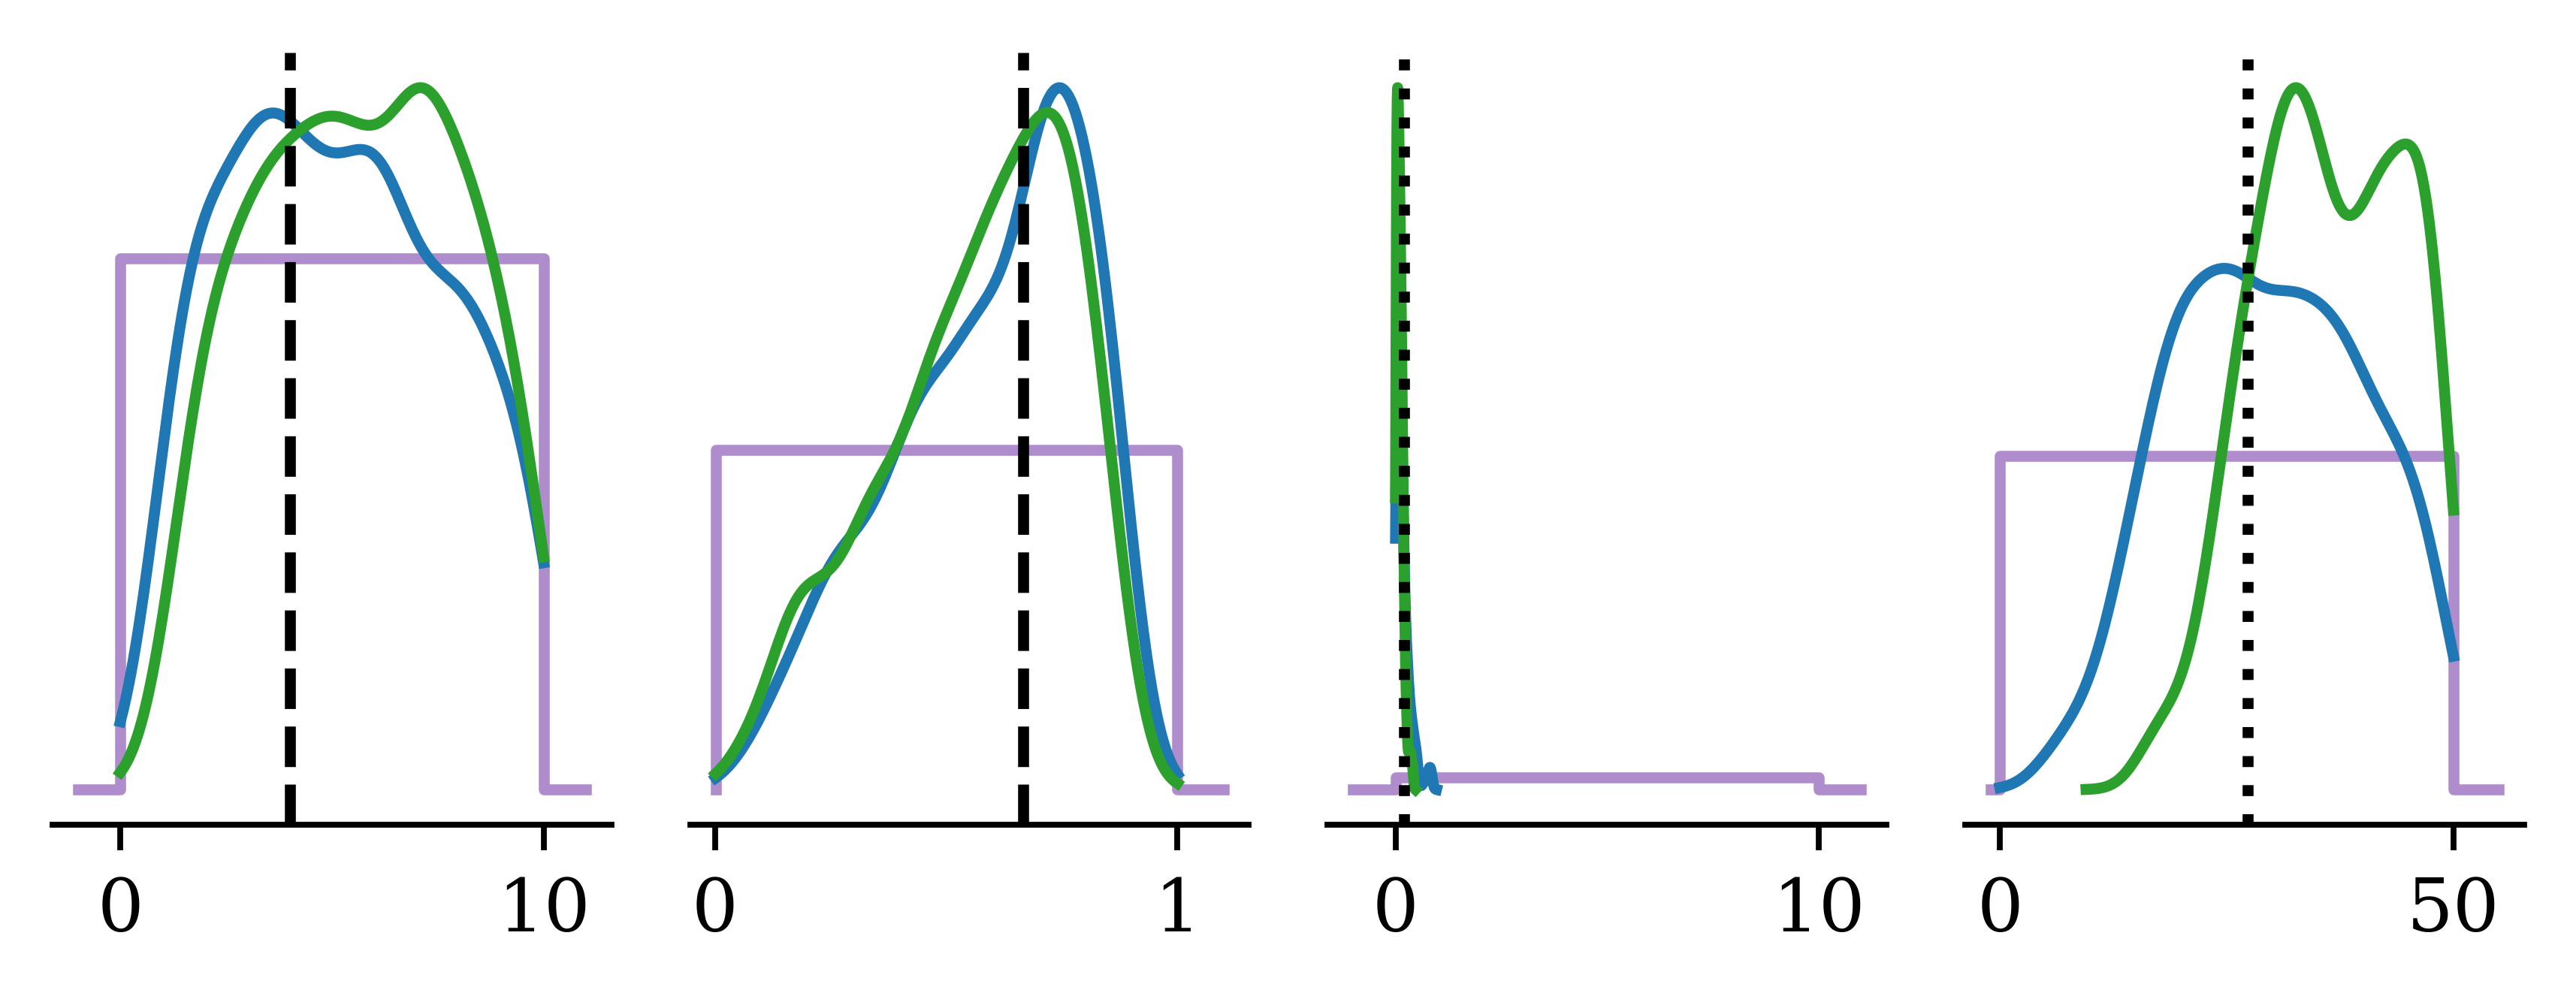

In [14]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_plot[l], **trueStyle)
    axs[l].axvline(θ_mle[l], **mleStyle)
    # axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-test1-negbin-gamma.pdf")

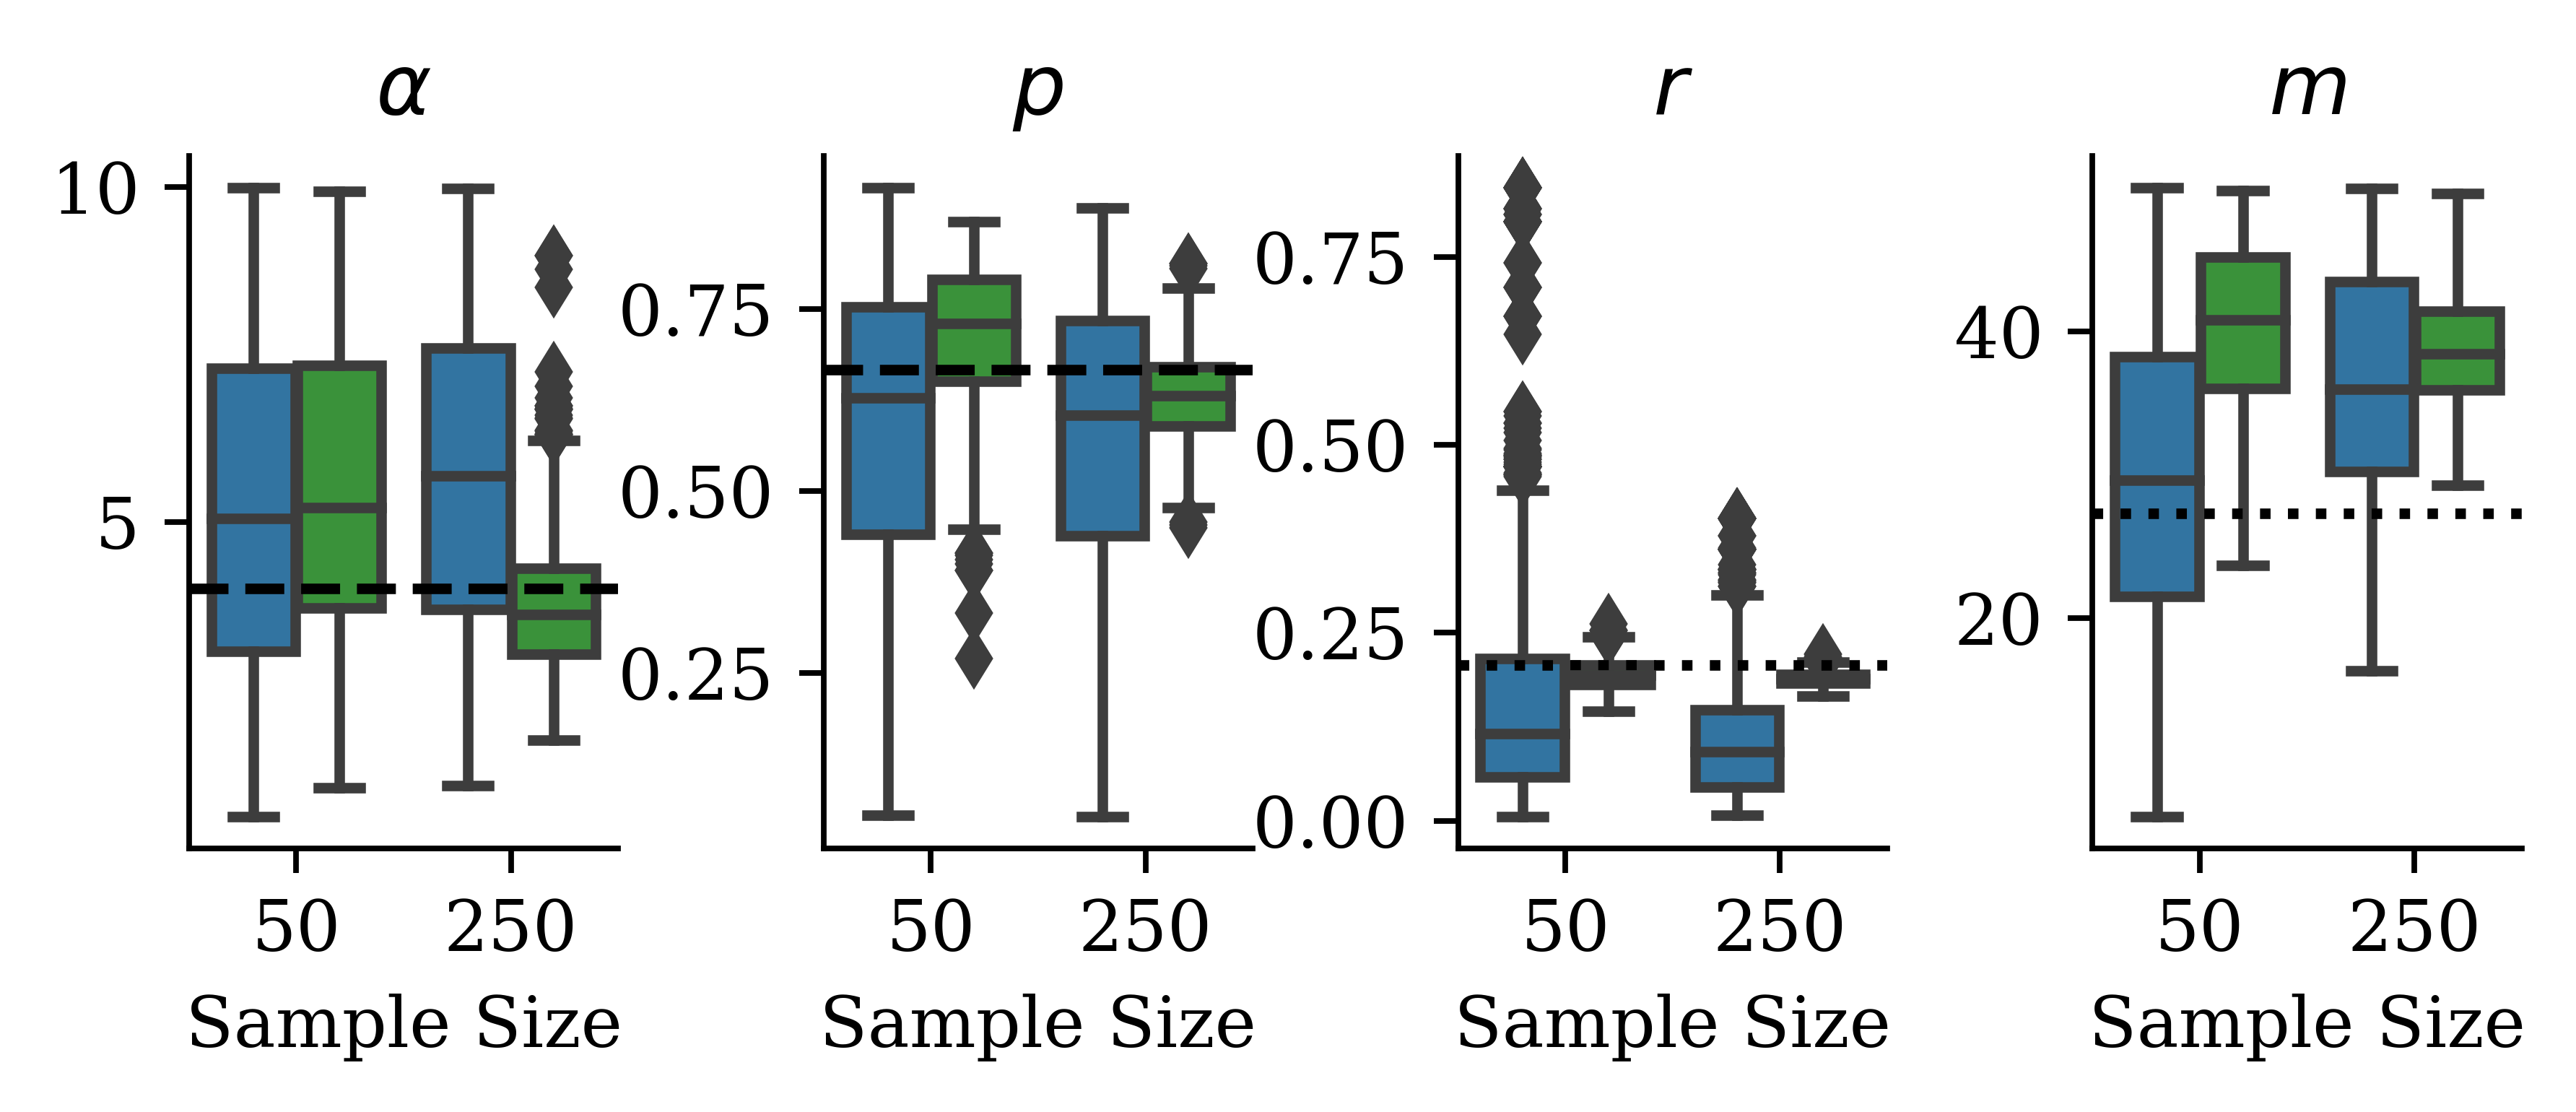

In [15]:
rg = default_rng(1)

n_resample = 1
resampled_post_ABC = pd.DataFrame(
    {"ss": np.concatenate([np.repeat(ss, popSize * n_resample) for ss in sample_sizes])}
)

for l in range(len(params)):
    res_param = np.array([])
    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled = sample[abcre.resample(rg, weights, repeats=n_resample)]
        res_param = np.concatenate([res_param, dataResampled])

    resampled_post_ABC[params[l]] = res_param
resampled_post_ABC["posterior"] = np.repeat(
    "ABC", len(sample_sizes) * popSize * n_resample
)
post_samples = pd.concat([resampled_post_ABC, dftrue], axis=0)
post_samples["ss"] = post_samples["ss"].astype(np.int64)

for l in range(len(params)):
    plt.subplot(1, 4, l + 1)
    plt.tight_layout(pad=0.0)
    sns.boxplot(x="ss", y=params[l], hue="posterior", data=post_samples)

    plt.axhline(θ_plot[l], **trueStyle)
    plt.axhline(θ_mle[l], **mleStyle)

    plt.title("$" + params[l] + "$")
    plt.ylabel("")
    plt.xlabel("Sample Size")
    plt.legend("", frameon=False)

sns.despine()
#save_cropped("../Figures/boxplot-test1-negbin-gamma.pdf")

## ABC posterior for the gamma parameters with the claim frequency

In [16]:
params = ("r", "m")
prior = abcre.IndependentUniformPrior([(0, 10), (0, 50)], params)

In [17]:
dfABC_freq = pd.DataFrame({"ss": [], "weights": [], "r": [], "m": []})

for ss in sample_sizes:
    xDataSS = df_agg.X[df_agg.time_period <= ss].to_numpy()
    nData = np.array(df_agg.N[df_agg.time_period <= ss])

    model = abcre.Model(nData, "gamma", psi, prior)

    %time fit = abcre.smc(numItersData, popSize, xDataSS, model, **smcArgs)

    res = pd.DataFrame(
        {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "r": fit.samples[:, 0],
            "m": fit.samples[:, 1],
        }
    )

    dfABC_freq = pd.concat([dfABC_freq, res])

Final population dists <= 7.13, ESS = 893
CPU times: user 20.1 s, sys: 854 ms, total: 21 s
Wall time: 41.6 s


Final population dists <= 4.97, ESS = 878
CPU times: user 18.7 s, sys: 893 ms, total: 19.6 s
Wall time: 1min 34s


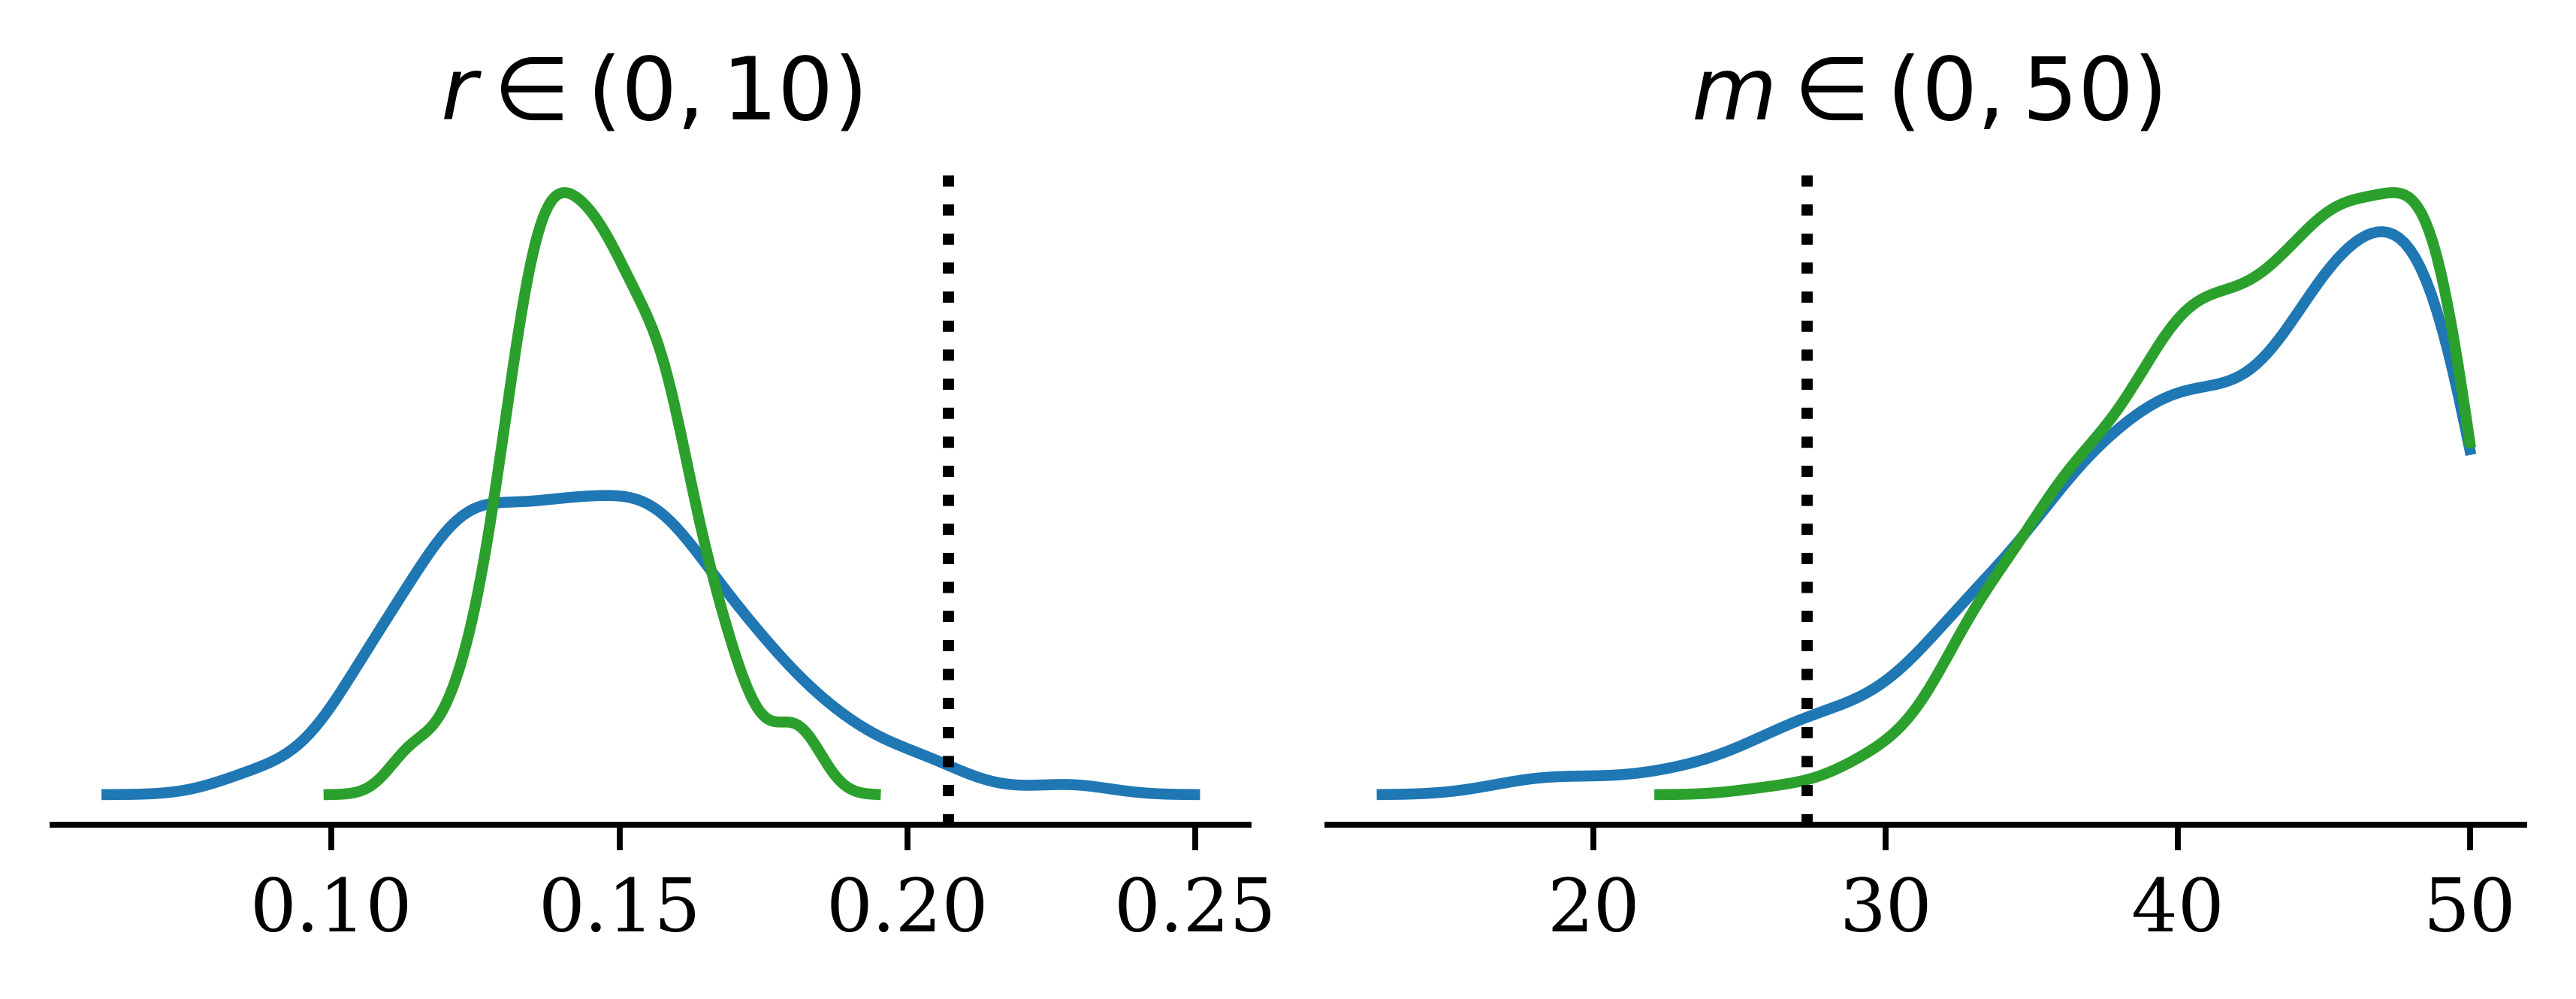

In [18]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

θ_gamma = r_mle, m_mle

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")
        axs[l].axvline(θ_gamma[l], **mleStyle)
        axs[l].set_title("$" + params[l] + f"\\in ({pLims[0]:.0f}, {pLims[1]:.0f})$")
        axs[l].set_yticks([])

        
sns.despine(left=True)
# save_cropped("../Figures/hist-test1-negbin-gamma-freq.pdf")

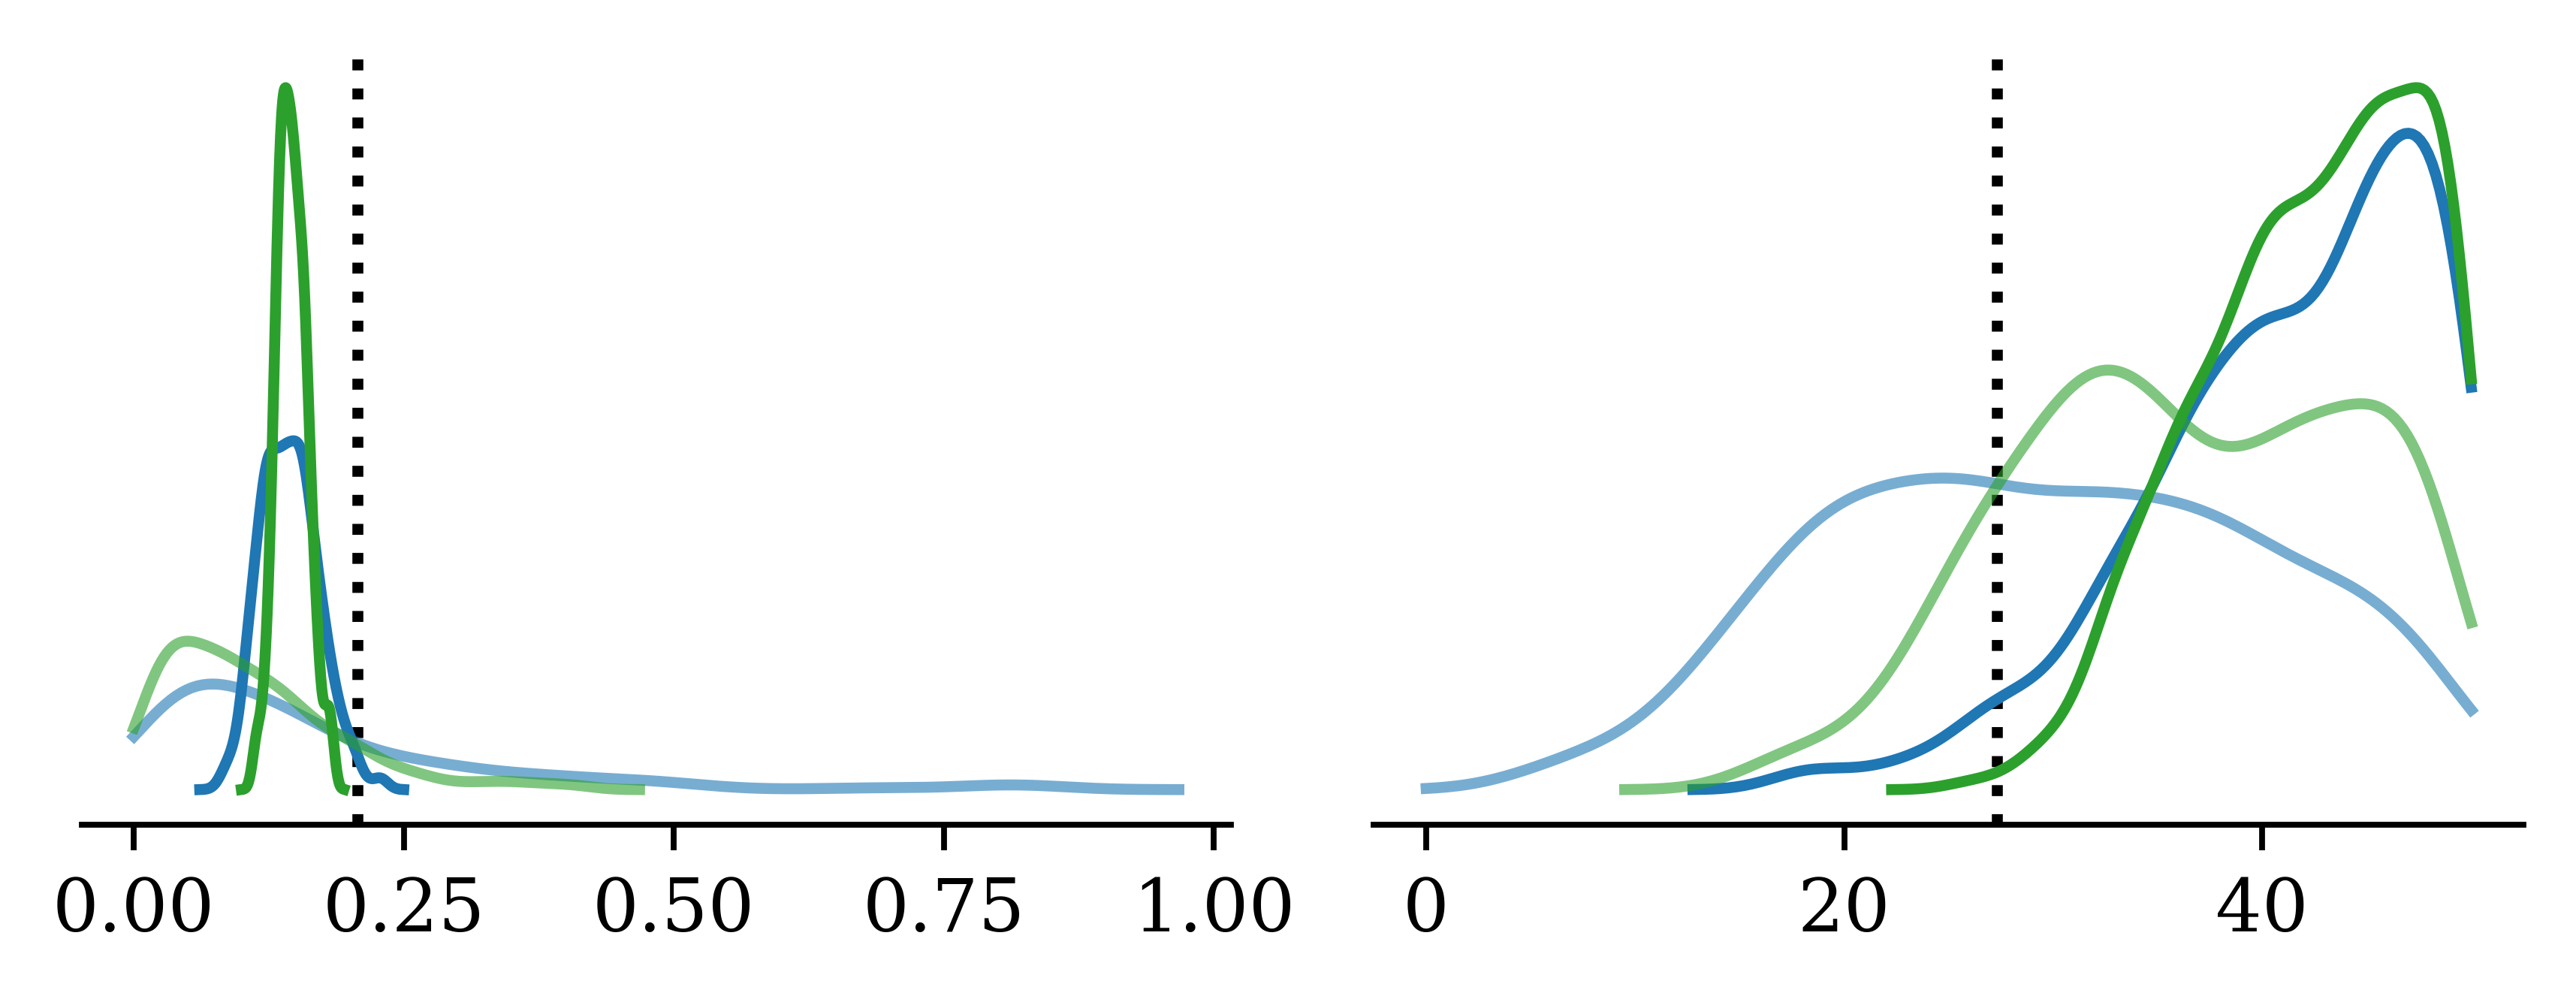

In [19]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

alphas = (0.6, 1)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    
    axs[l].axvline(θ_gamma[l], **mleStyle)
    axs[l].set_yticks([])
    for k, ss in enumerate(sample_sizes):
        
        for j, df in enumerate((dfABC, dfABC_freq)):
            sampleData = df.query("ss == @ss")
            sample = sampleData[params[l]]
            weights = sampleData["weights"]

            dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label="ABC", alpha=alphas[j], c=colors[k])
            
            # axs[l].set_title("$" + params[l] + "$")
            
sns.despine(left=True)
save_cropped("../Figures/hist-test1-negbin-gamma-both.pdf")

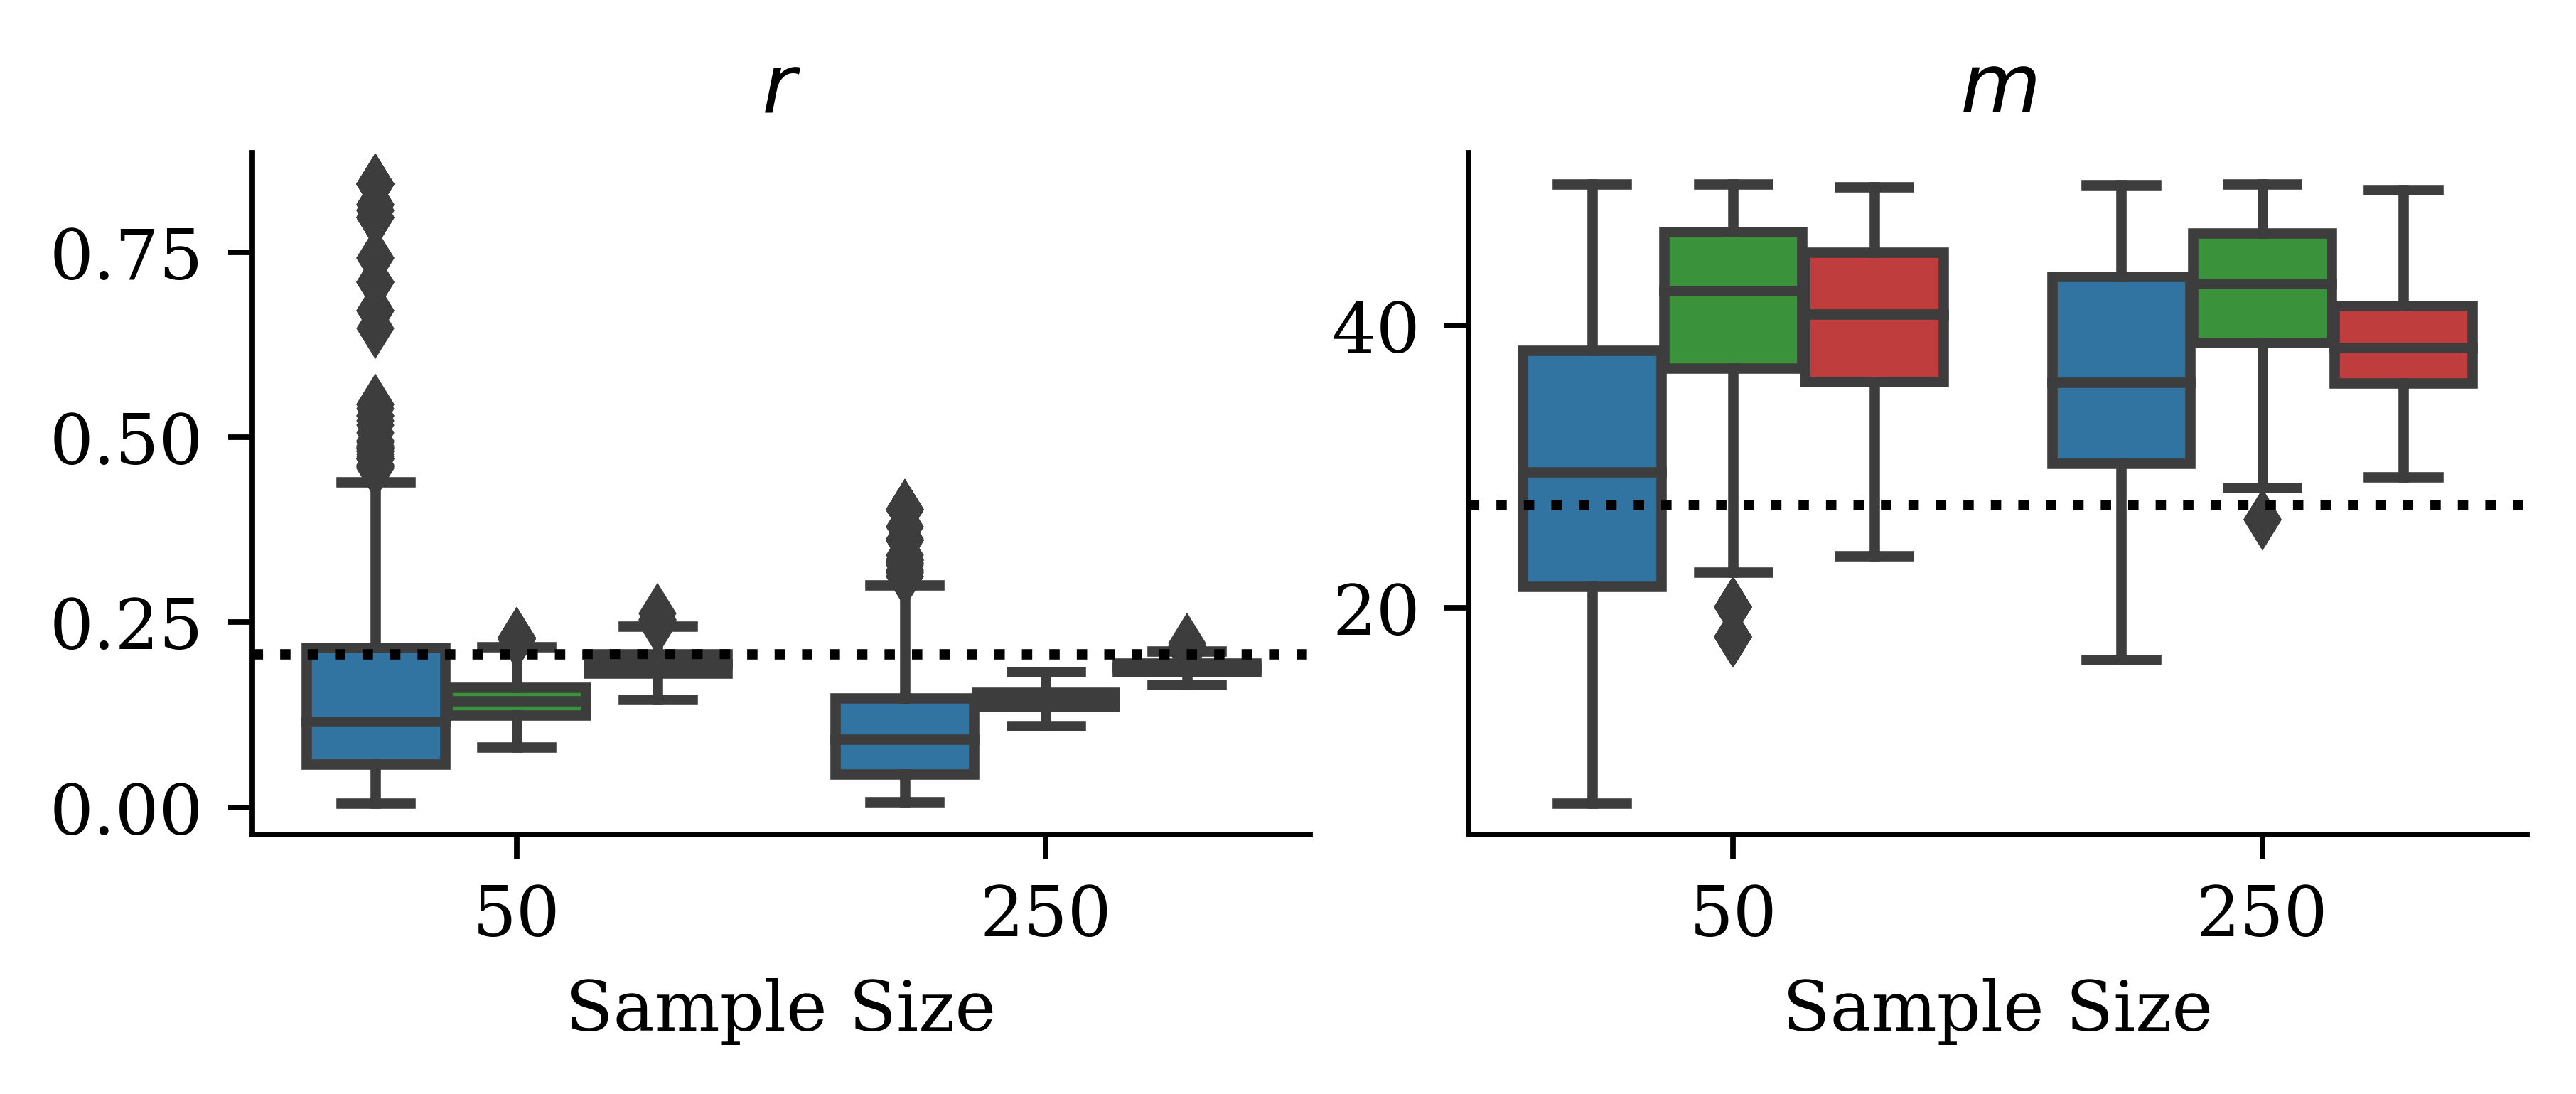

In [20]:
rg = default_rng(1)

resampled_post_ABC_freq = pd.DataFrame(
    {"ss": np.concatenate([np.repeat(ss, popSize * n_resample) for ss in sample_sizes])}
)

for l in range(len(params)):
    res_param = np.array([])
    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled = sample[abcre.resample(rg, weights, repeats=n_resample)]
        res_param = np.concatenate([res_param, dataResampled])

    resampled_post_ABC_freq[params[l]] = res_param
resampled_post_ABC_freq["posterior"] = np.repeat(
    "ABC with freq.", len(sample_sizes) * popSize * n_resample
)
dfV2 = pd.concat([resampled_post_ABC, resampled_post_ABC_freq, dftrue], axis=0)
dfV2["ss"] = dfV2["ss"].astype(np.int64)

for l in range(len(params)):
    plt.subplot(1, len(params), l + 1)
    plt.tight_layout(pad=0.0)
    sns.boxplot(x="ss", y=params[l], hue="posterior", data=dfV2)

    plt.axhline(θ_gamma[l], **mleStyle)

    plt.title("$" + params[l] + "$")
    plt.ylabel("")
    plt.xlabel("Sample Size")
    plt.legend("", frameon=False)

sns.despine()
#save_cropped("../Figures/boxplot-test1-negbin-gamma-freq.pdf")

In [21]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 202 secs = 3.37 mins


In [22]:
dill.dump_session("Sim_NegBin_Gamma.pkl")